# Cascade Controller

In this example we demonstrate a cascade control architecture with a two-loop PID control system. Cascade control is widely used in process control when a fast inner loop can help improve the performance of a slower outer loop.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_cascade.py).

## System Architecture

The cascade controller consists of:
- An **outer loop** (primary controller) that regulates the main process variable
- An **inner loop** (secondary controller) that controls an intermediate variable
- A **plant** modeled as a subsystem with two cascaded transfer functions and noise disturbances

The inner loop responds faster to disturbances, improving the overall system response.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection, Subsystem, Interface
from pathsim.blocks import Source, TransferFunctionZPG, Adder, Scope, PID, WhiteNoise
from pathsim.solvers import RKCK54

In [3]:
# Define the plant as a subsystem
in1 = Interface()

p1 = TransferFunctionZPG(Zeros=[], Poles=[-1, -1, -1], Gain=10)
p2 = TransferFunctionZPG(Zeros=[], Poles=[-2], Gain=3)

a1 = Adder()
a2 = Adder()

d1 = WhiteNoise(spectral_density=5e-5)
d2 = WhiteNoise(spectral_density=5e-5)

plant = Subsystem(
    blocks=[p1, p2, a1, a2, d1, d2, in1],
    connections=[
        Connection(in1, p2),
        Connection(p2, a2[0]),
        Connection(d2, a2[1]),
        Connection(a2, p1, in1[1]),
        Connection(p1, a1[0]),
        Connection(d1, a1[1]),
        Connection(a1, in1[0])
    ]
)

In [5]:
# Source function with changing setpoints
def f_s(t):
    if t > 60:
        return 0.5
    elif t > 20:
        return 1
    else:
        return 0

stp = Source(f_s)

# PID controllers
c1 = PID(Kp=0.015, Ki=0.015/0.716, Kd=0.0, f_max=10.0)  # Outer loop
c2 = PID(Kp=0.244, Ki=0.244/0.134, Kd=0.0, f_max=10.0)  # Inner loop

# Error calculation blocks
e1 = Adder("+-")
e2 = Adder("+-")

# Scopes for monitoring
sc0 = Scope(labels=["setpoint", "plant 1", "plant 2"])
sc1 = Scope(labels=["err 1", "pid 1"])
sc2 = Scope(labels=["err 2", "pid 2"])

In [7]:
Sim = Simulation(
    blocks=[stp, plant, c1, c2, e1, e2, sc0, sc1, sc2],
    connections=[
        Connection(stp, e1[0], sc0[0]),
        Connection(plant[0], e1[1], sc0[1]),
        Connection(e1, c1, sc1[0]),
        Connection(c1, e2[0], sc1[1]),
        Connection(plant[1], e2[1], sc0[2]),
        Connection(e2, c2, sc2[0]),
        Connection(c2, plant, sc2[1])
    ],
    Solver=RKCK54,
    tolerance_lte_rel=1e-4,
    tolerance_lte_abs=1e-6
)

2025-10-10 14:11:44,013 - INFO - LOGGING (log: True)
2025-10-10 14:11:44,014 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-10 14:11:44,015 - INFO - BLOCK (type: Subsystem, dynamic: True, events: 0)
2025-10-10 14:11:44,015 - INFO - BLOCK (type: PID, dynamic: True, events: 0)
2025-10-10 14:11:44,015 - INFO - BLOCK (type: PID, dynamic: True, events: 0)
2025-10-10 14:11:44,015 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 14:11:44,016 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 14:11:44,016 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 14:11:44,016 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 14:11:44,017 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 14:11:44,017 - INFO - GRAPH (size: 9, alg. depth: 5, loop depth: 0, runtime: 0.209ms)


Now let's run the simulation for 100 seconds:

In [10]:
# Run the simulation
Sim.run(100)

2025-10-10 14:11:47,235 - INFO - STARTING -> TRANSIENT (Duration: 100.00s)
2025-10-10 14:11:47,236 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-10 14:11:47,486 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: 00:00:01) | 592 steps (2361.9 steps/s)
2025-10-10 14:11:47,649 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: 00:00:00) | 989 steps (2434.9 steps/s)
2025-10-10 14:11:47,823 - INFO - TRANSIENT:  60% | elapsed: 00:00:00 (eta: 00:00:00) | 1401 steps (2385.3 steps/s)
2025-10-10 14:11:47,989 - INFO - TRANSIENT:  80% | elapsed: 00:00:00 (eta: 00:00:00) | 1808 steps (2447.6 steps/s)
2025-10-10 14:11:48,142 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: 00:00:00) | 2181 steps (2437.4 steps/s)
2025-10-10 14:11:48,143 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: 00:00:00) | 2181 steps (2405.2 avg steps/s)
2025-10-10 14:11:48,143 - INFO - FINISHED -> TRANSIENT (total steps: 2181, successful: 1599, runtime: 906.78 ms)


{'total_steps': 2181, 'successful_steps': 1599, 'runtime_ms': 906.776700001501}

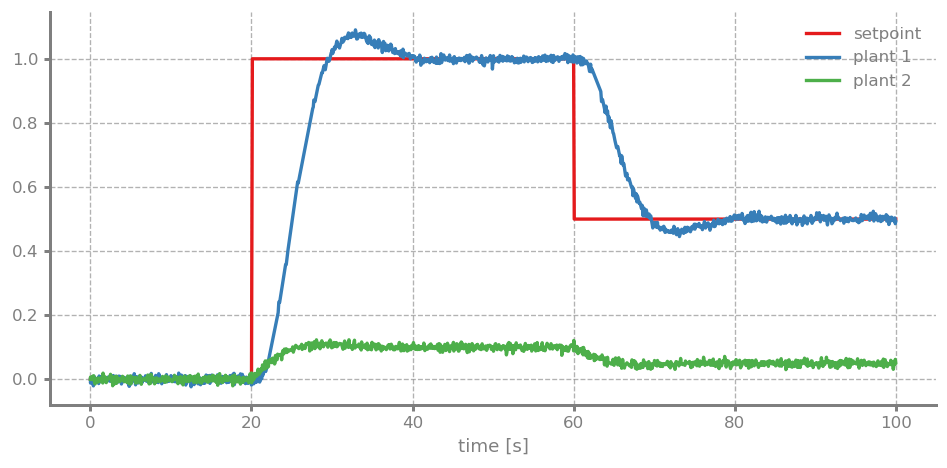

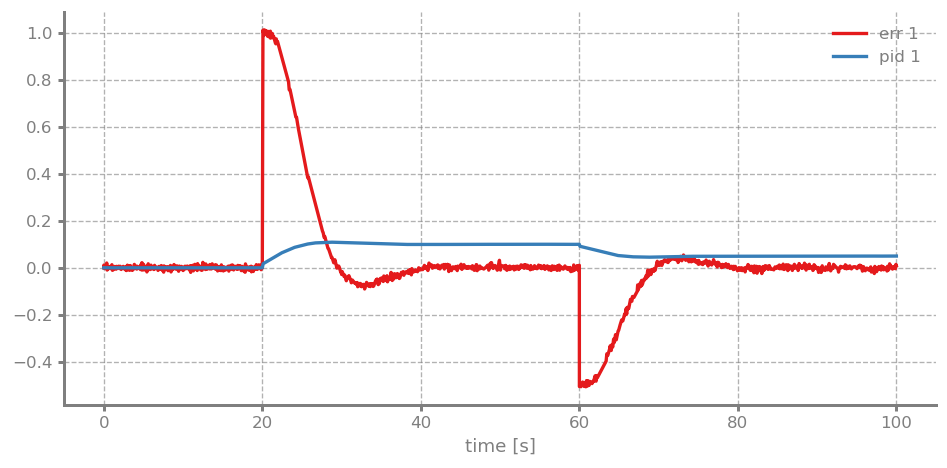

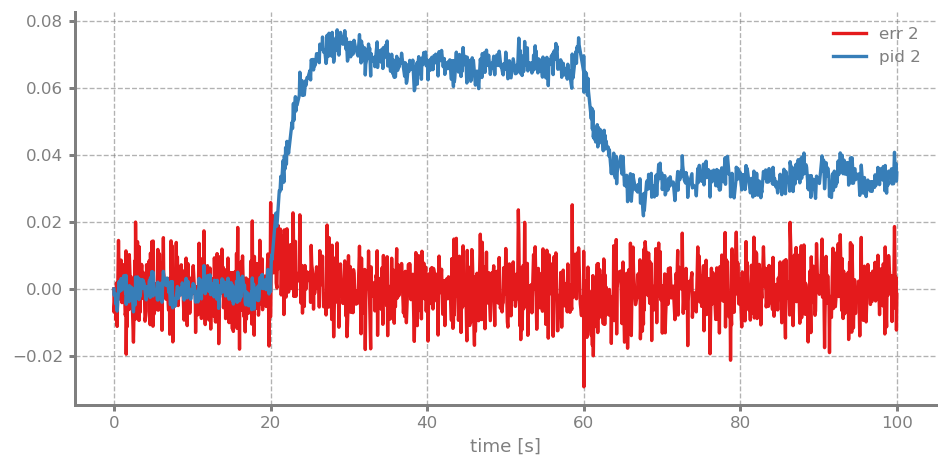

In [12]:
# Plot all scopes
Sim.plot()
plt.show()